# **Débruitage** 

Gaetano Agazzotti, Jules Chapon, Corentin Pernot 


# 📝 **Plan du Notebook**

---

### **I - Description des données**
- Analyse des **statistiques descriptives**.
- Identification des **problèmes et limitations** dans les données.

---

### **II - Modèle de référence : Filtre de Wiener**
- Présentation du **modèle de base**.
- Analyse des **résultats obtenus**.

---

### **III - Travail sur le spectrogramme**
- Approche basée sur le **masquage spectral**.
- Utilisation d'un **U-Net** pour le traitement des spectrogrammes.

---

### **IV - Travail sur la forme d'onde**
- Implémentation du modèle **Wave-U-Net**.
- Référence : *D. Stoller et al., "Wave-U-Net: A Multi-Scale Neural Network for End-to-End Audio Source Separation," ISMIR 2018*.

---

### **V - Conclusion**
- Synthèse des résultats.


# **I - Analyse des données**

In [43]:
import numpy as np
import torch 
import matplotlib.pyplot as plt 
from src.libs.preprocessing import DataLoader
from tqdm import tqdm
import numpy as np
from scipy.fft import fft, ifft
from src.libs.evaluation import eval_signal, eval_all_signals
from IPython.display import Audio
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from src.model.mask_unet import UNet
from src.libs.preprocessing import DataLoader
from src.libs.postprocessing import (
    get_unet,
    invert_spectrogram,
    upsample_spectrogram,
    Spectrogram,
)

from src.libs.visualization import plot_spectrograms

In [5]:
import os
os.chdir('dlsp-denoising')
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/Deep Learning et traitement du signal/projet_final/dlsp-denoising


In [9]:
small_data_set = False

if small_data_set:
    path_train_x = "data/input/denoising/train_small"
    path_train_y = "data/input/voice_origin/train_small"
    path_test_x = "data/input/denoising/test_small"
    path_test_y = "data/input/voice_origin/test_small"
else:
    path_train_x = "data/input/denoising/train"
    path_train_y = "data/input/voice_origin/train"
    path_test_x = "data/input/denoising/test"
    path_test_y = "data/input/voice_origin/test"

print("TRAIN")
data_loader_train = DataLoader(path_x=path_train_x, path_y=path_train_y)

harmonized_data_train = data_loader_train.get_harmonized_data(
    downsample=small_data_set) 

print("______________")
print("TEST")

data_loader_test = DataLoader(path_x=path_test_x, path_y=path_test_y)
harmonized_data_test = data_loader_test.get_harmonized_data(
    downsample=small_data_set) 

TRAIN
Import summary:
- Data imported successfully!
- Number of noised samples: 2118
- Number of original samples: 2118
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: True.
______________
TEST
Import summary:
- Data imported successfully!
- Number of noised samples: 608
- Number of original samples: 782
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: False.


In [13]:
file_number = 5
f_sampling = 8000
train_x, train_y = harmonized_data_train.x[file_number], harmonized_data_train.y[file_number]

Signal bruité :


Signal original :


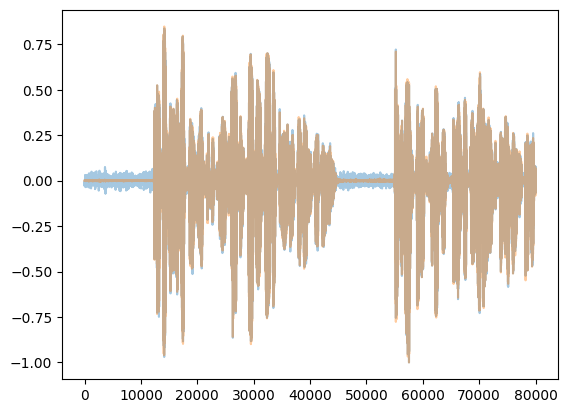

In [14]:
plt.plot(train_x, alpha=0.4)
plt.plot(train_y, alpha=0.4)
print("Signal bruité :")
display(Audio(train_x, rate=f_sampling))
print("Signal original :")
display(Audio(train_y, rate=f_sampling))

In [55]:
def eval_all_signals(list_signals_pred, list_signals_target, f_sampling):
    " Iterations sur tous les signaux "
    MSE = []
    RMSE = []
    SNR = []
    STOI_results = []
    PESQ_results = []
    for i, signal_pred in tqdm(enumerate(list_signals_pred), total=len(list_signals_pred)):
        signal_target = list_signals_target[i]
        mse, rmse, snr, stoi_result, pesq_result = eval_signal(signal_pred, signal_target, f_sampling)
        MSE.append(mse)
        RMSE.append(rmse)
        SNR.append(snr)
        STOI_results.append(stoi_result)
        PESQ_results.append(pesq_result)
    return MSE, RMSE, SNR, STOI_results, PESQ_results


def summary_eval(MSE, RMSE, SNR, STOI_results, PESQ_results):
    print("Metric : mean (std)")
    print("___________________")
    print(f"MSE   : {np.mean(MSE):.4f} ({np.std(MSE):.4f})")
    print(f"RMSE  : {np.mean(RMSE):.4f} ({np.std(RMSE):.4f})")
    print(f"SNR   : {np.mean(SNR):.4f} ({np.std(SNR):.4f})")
    print(f"STOI  : {np.mean(STOI_results):.4f} ({np.std(STOI_results):.4f})")
    print(f"PESQ  : {np.mean(PESQ_results):.4f} ({np.std(PESQ_results):.4f})")

In [20]:
MSE, RMSE, SNR, STOI_results, PESQ_results = eval_all_signals(harmonized_data_train.x, harmonized_data_train.y, f_sampling)

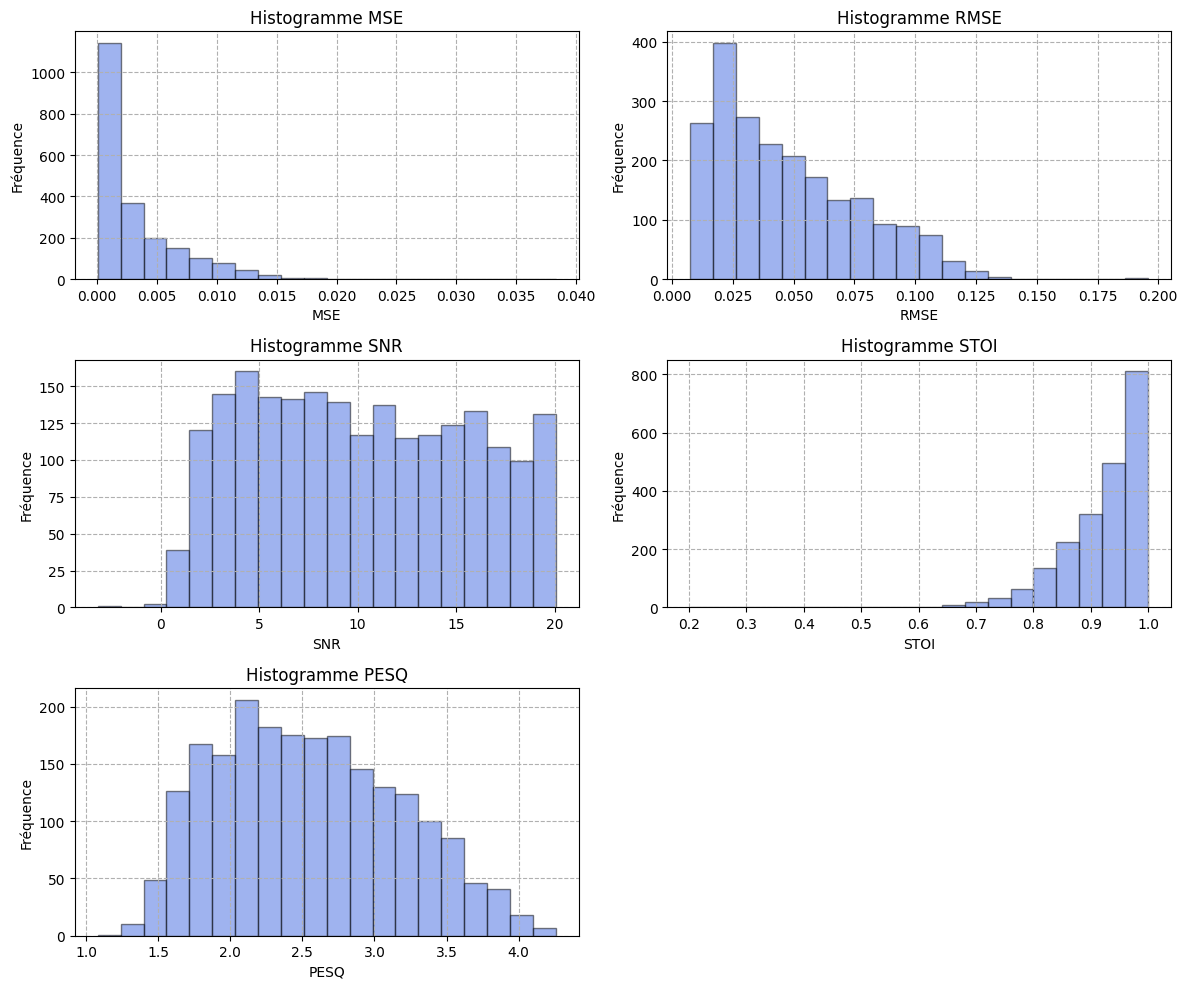

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10)) 

# Histogramme MSE
axs[0, 0].hist(MSE, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[0, 0].grid(linestyle="--")
axs[0, 0].set_title('Histogramme MSE')
axs[0, 0].set_xlabel('MSE')
axs[0, 0].set_ylabel('Fréquence')

# Histogramme RMSE
axs[0, 1].hist(RMSE, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[0, 1].grid(linestyle="--")
axs[0, 1].set_title('Histogramme RMSE')
axs[0, 1].set_xlabel('RMSE')
axs[0, 1].set_ylabel('Fréquence')

# Histogramme SNR
axs[1, 0].hist(SNR, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[1, 0].grid(linestyle="--")
axs[1, 0].set_title('Histogramme SNR')
axs[1, 0].set_xlabel('SNR')
axs[1, 0].set_ylabel('Fréquence')

# Histogramme STOI
axs[1, 1].hist(STOI_results, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[1, 1].grid(linestyle="--")
axs[1, 1].set_title('Histogramme STOI')
axs[1, 1].set_xlabel('STOI')
axs[1, 1].set_ylabel('Fréquence')

# Histogramme PESQ
axs[2, 0].hist(PESQ_results, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[2, 0].grid(linestyle="--")
axs[2, 0].set_title('Histogramme PESQ')
axs[2, 0].set_xlabel('PESQ')
axs[2, 0].set_ylabel('Fréquence')

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

In [28]:
# Pire cas 
file_number = np.argmin(STOI_results)
Audio(harmonized_data_train.x[file_number], rate=f_sampling)

In [29]:
# Meilleur cas 
file_number = np.argmax(STOI_results)
Audio(harmonized_data_train.x[file_number], rate=f_sampling)

In [30]:
correlation = np.corrcoef(STOI_results, PESQ_results)[0, 1]

print(f"Corrélation entre STOI et PESQ : {correlation}")

Corrélation entre STOI et PESQ : 0.6772533607715068


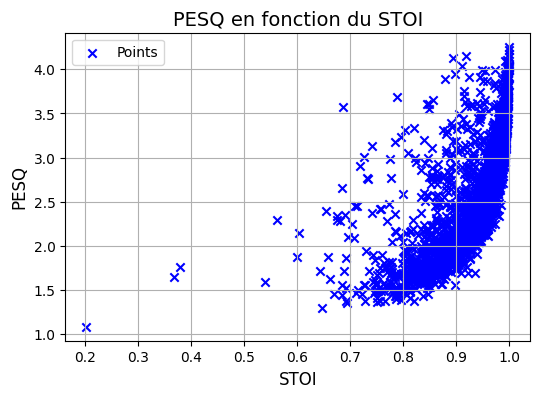

In [31]:
plt.figure(figsize=(6, 4))  
plt.scatter(STOI_results, PESQ_results, marker='x', color='blue', label='Points') 
plt.xlabel("STOI", fontsize=12)
plt.ylabel("PESQ", fontsize=12)
plt.title("PESQ en fonction du STOI", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### Analyses :
- Uniformité dans la longueur et dans le fréquence d'échantillonnage
- Niveau de complexité différents en fonction du bruitage initial
- Challenge dans l'évaluation des performances : métrique MSE et RMSE mais aussi PESQ et STOI et surtout le rendu à l'oreille. 

# **II- Modèle baseline : Filtre de Wiener**

In [33]:
## Idée : utiliser les données du train pour construire le filtre

P_x_list = []
P_b_list = []

for x_train, y_train in tqdm(zip(harmonized_data_train.x, harmonized_data_train.y)):
    # estimation du bruit : B = X - Y
    b_train = x_train - y_train

    # transformées de Fourier des signaux bruité et propre
    X_f = np.fft.fft(x_train)
    B_f = np.fft.fft(b_train)

    # DSP
    P_x = np.abs(X_f)**2  # Spectre de puissance signal bruité
    P_b = np.abs(B_f)**2  # Spectre de puissance bruit estimé

    P_x_list.append(P_x)
    P_b_list.append(P_b)

# On estime le bruit moyen
P_x_mean = np.mean(P_x_list, axis=0)  # Moyennesur signaux bruités
P_b_mean = np.mean(P_b_list, axis=0)  # Moyenne sur bruit

# Filtre de Wiener comme dans le cours : H(f) = (P_x(f) - P_b(f)) / P_x(f)
H_f = (P_x_mean - P_b_mean) / P_x_mean
































































































































































































































































































































































































2118it [00:24, 86.93it/s]


###  Exemple 

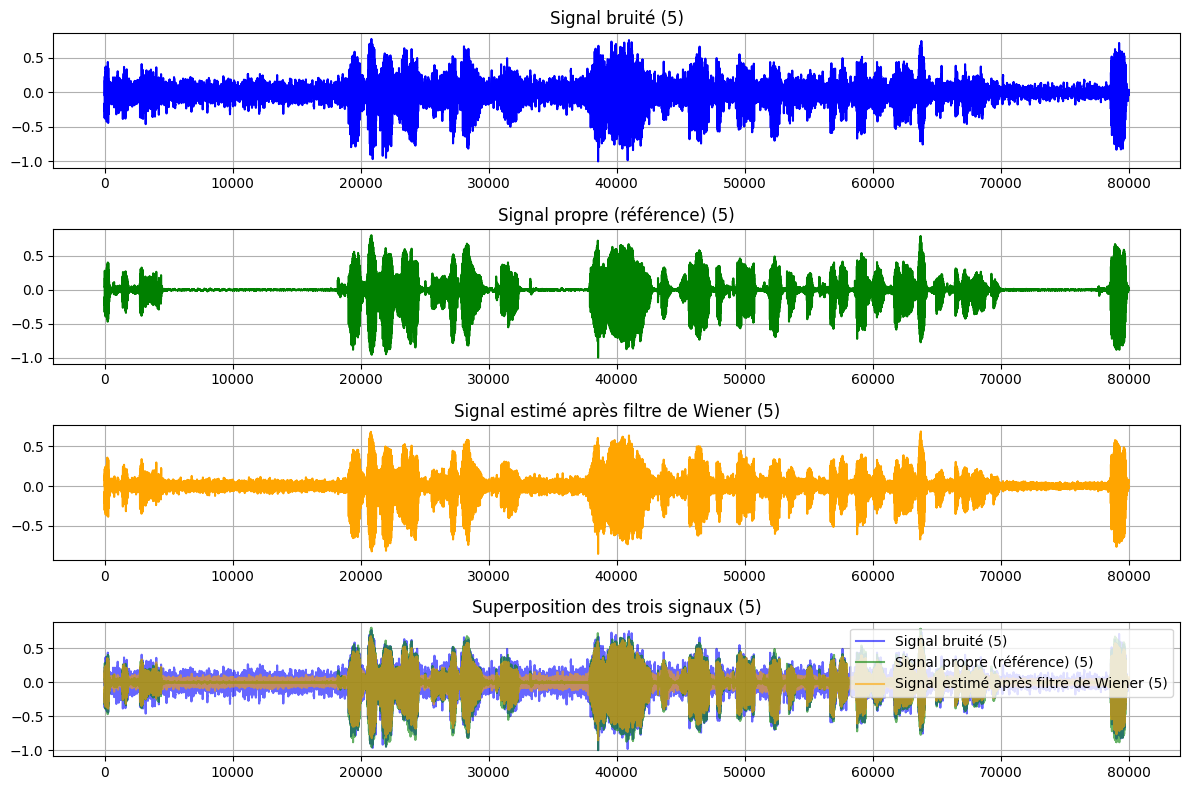

Signal bruité : 


Signal débruité : 


Signal target : 


In [36]:
i = 5 # exemple à choisir
x_test = harmonized_data_test.x[i]

# Appliquer le filtre de Wiener 
X_f_test = np.fft.fft(x_test)
X_f_test_est = H_f * X_f_test
x_test_est = np.fft.ifft(X_f_test_est)

# Affichage 
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(np.real(x_test), label=f'Signal bruité ({i})', color="blue")
plt.title(f'Signal bruité ({i})')
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(np.real(harmonized_data_test.y[i]), label=f'Signal propre (référence) ({i})', color="green")
plt.title(f'Signal propre (référence) ({i})')
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(np.real(x_test_est), label=f'Signal estimé après filtre de Wiener ({i})', color="orange")
plt.title(f'Signal estimé après filtre de Wiener ({i})')
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(np.real(x_test), label=f'Signal bruité ({i})', color="blue", alpha=0.6)
plt.plot(np.real(harmonized_data_test.y[i]), label=f'Signal propre (référence) ({i})', color="green", alpha=0.6)
plt.plot(np.real(x_test_est), label=f'Signal estimé après filtre de Wiener ({i})', color="orange", alpha=0.6)
plt.title(f'Superposition des trois signaux ({i})')
plt.legend(loc="upper right")
plt.grid()

plt.tight_layout()
plt.show()

print("Signal bruité : ")
display(Audio(np.real(x_test), rate=8000))

print("Signal débruité : ")
display(Audio(np.real(x_test_est), rate=8000))

print("Signal target : ")
display(Audio(np.real(harmonized_data_test.y[i]), rate=8000))


In [37]:
signaux_debruites = []

for i, x_test in tqdm(enumerate(harmonized_data_test.x)):
    # On applique le filtre de Wiener 
    X_f_test = np.fft.fft(x_test)
    X_f_test_est = H_f * X_f_test
    x_test_est = np.fft.ifft(X_f_test_est)

    signaux_debruites.append(np.real(x_test_est))





































608it [00:01, 339.02it/s]


In [40]:
MSE, RMSE, SNR, STOI_results, PESQ_results = eval_all_signals(harmonized_data_test.x, harmonized_data_test.y, 8000)
MSE_wiener, RMSE_wiener, SNR_wiener, STOI_results_wiener, PESQ_results_wiener = eval_all_signals(signaux_debruites, harmonized_data_test.y, 8000)
summary_eval(MSE_wiener, RMSE_wiener, SNR_wiener, STOI_results_wiener, PESQ_results_wiener)

Metric : mean (std)
___________________
MSE   : 0.0009 (0.0011)
RMSE  : 0.0258 (0.0143)
SNR   : 14.8739 (4.0047)
STOI  : 0.9314 (0.0684)
PESQ  : 2.6330 (0.6391)


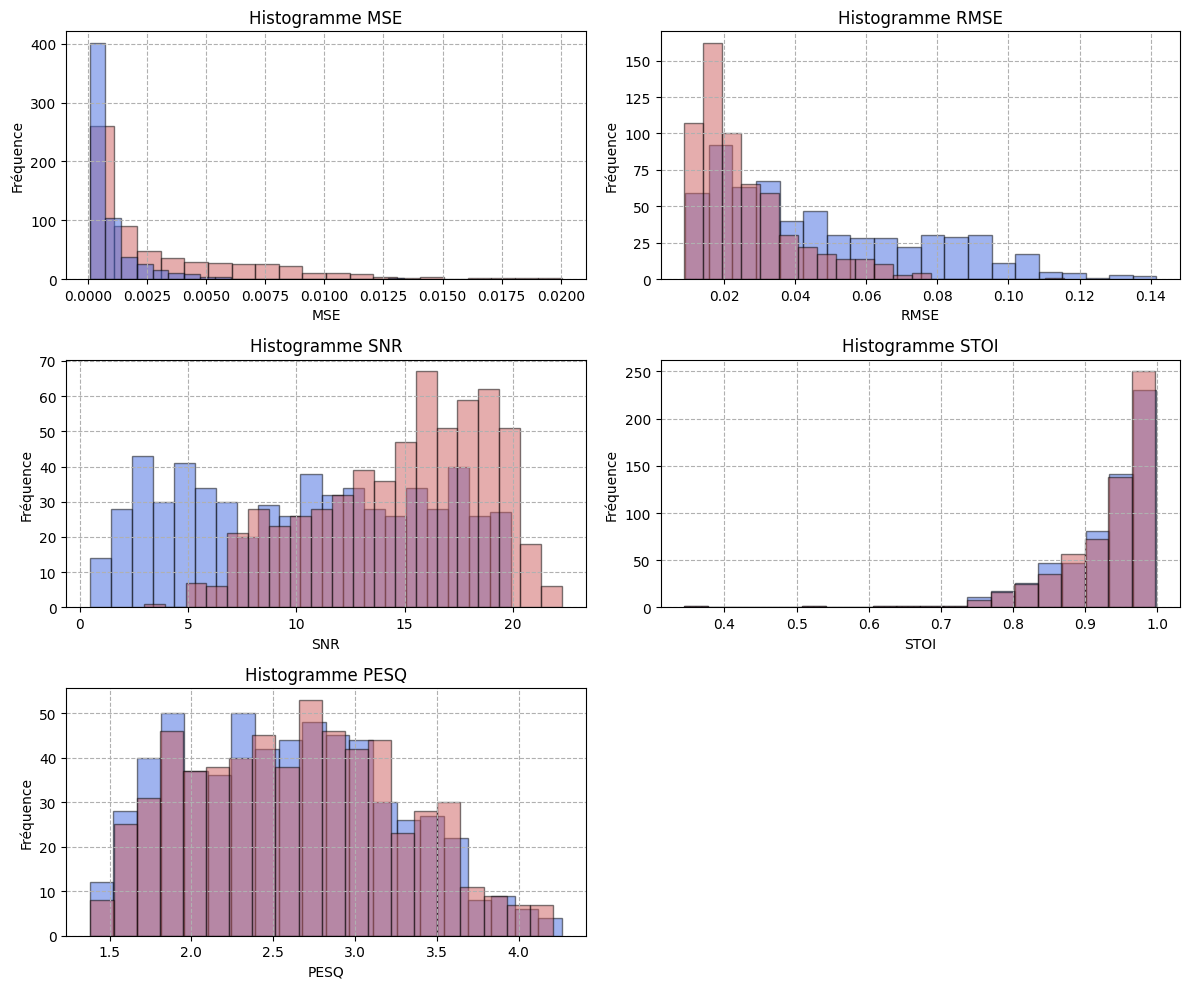

In [41]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10)) 

# Histogramme MSE
axs[0, 0].hist(MSE, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[0, 0].hist(MSE_wiener, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[0, 0].grid(linestyle="--")
axs[0, 0].set_title('Histogramme MSE')
axs[0, 0].set_xlabel('MSE')
axs[0, 0].set_ylabel('Fréquence')

# Histogramme RMSE
axs[0, 1].hist(RMSE, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[0, 1].hist(RMSE_wiener, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[0, 1].grid(linestyle="--")
axs[0, 1].set_title('Histogramme RMSE')
axs[0, 1].set_xlabel('RMSE')
axs[0, 1].set_ylabel('Fréquence')

# Histogramme SNR
axs[1, 0].hist(SNR, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[1, 0].hist(SNR_wiener, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[1, 0].grid(linestyle="--")
axs[1, 0].set_title('Histogramme SNR')
axs[1, 0].set_xlabel('SNR')
axs[1, 0].set_ylabel('Fréquence')

# Histogramme STOI
axs[1, 1].hist(STOI_results, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[1, 1].hist(STOI_results_wiener, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[1, 1].grid(linestyle="--")
axs[1, 1].set_title('Histogramme STOI')
axs[1, 1].set_xlabel('STOI')
axs[1, 1].set_ylabel('Fréquence')

# Histogramme PESQ
axs[2, 0].hist(PESQ_results, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[2, 0].hist(PESQ_results_wiener, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[2, 0].grid(linestyle="--")
axs[2, 0].set_title('Histogramme PESQ')
axs[2, 0].set_xlabel('PESQ')
axs[2, 0].set_ylabel('Fréquence')

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

### Analyses : 
- Améliore légèrement les performances, notamment la RMSE et le SNR
- Néanmoins cela est loin d'être satisfaisant pour le rendu à l'oreille. 

# **III - Travail sur le spectrogramme, approche par masquage : U-net**

## **III-1- Spectrogramme** 

# A REMPLIR

signal --> spectrogramme --> traitement --> inversion --> signal
### Méthodologie : débruiter le spectrogramme, l'inver

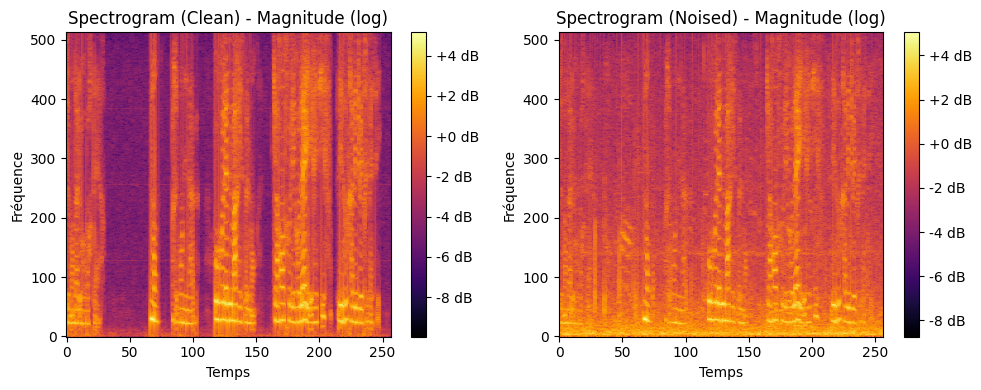

In [45]:
file_number = 10
test_x, test_y = harmonized_data_train.x[file_number], harmonized_data_train.y[file_number]

signal_clean = torch.tensor(test_y)
spect_clean = Spectrogram(signal_clean)

signal_noised = torch.tensor(test_x)
spect_noised = Spectrogram(signal_noised)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(
    spect_clean.magnitude.numpy(), aspect="auto", cmap="inferno", origin="lower"
)
axes[0].set_title("Spectrogram (Clean) - Magnitude (log)")
axes[0].set_xlabel("Temps")
axes[0].set_ylabel("Fréquence")
fig.colorbar(im0, ax=axes[0], format="%+2.0f dB")

im1 = axes[1].imshow(
    spect_noised.magnitude.numpy(), aspect="auto", cmap="inferno", origin="lower"
)
axes[1].set_title("Spectrogram (Noised) - Magnitude (log)")
axes[1].set_xlabel("Temps")
axes[1].set_ylabel("Fréquence")
fig.colorbar(im1, ax=axes[1], format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [46]:

print("Signal bruité : ")
display(Audio(np.real(test_x), rate=8000))

print("Signal débruité : ")
display(Audio(np.real(test_y), rate=8000))


Signal bruité : 


Signal débruité : 


In [47]:
post_name = "20241222_130207"
model_loaded = get_unet(post_name=post_name)

In [48]:
path_test_x = "data/input/denoising/test"
path_test_y = "data/input/voice_origin/test"
data_loader = DataLoader(path_x=path_test_x, path_y=path_test_y)
harmonized_data = data_loader.get_harmonized_data()

Import summary:
- Data imported successfully!
- Number of noised samples: 608
- Number of original samples: 782
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: False.


In [49]:
spectrogram_noised = Spectrogram(torch.tensor(test_x))
mask = model_loaded(spectrogram_noised.magnitude[:-1, :-1].float()[None, None, :])
denoised_output = mask * spectrogram_noised.magnitude[:-1, :-1]
denoised_output_upsample = upsample_spectrogram(denoised_output)
denoised_output_upsample_complex = torch.exp(
    denoised_output_upsample + 1j * spectrogram_noised.angle
)[0, 0]
denoised_signal = invert_spectrogram(
    denoised_output_upsample_complex,
    n_fft=spectrogram_noised.n_fft,
    hop_length=spectrogram_noised.hop_length,
    win_length=spectrogram_noised.win_length,
    length=spectrogram_noised.signal.shape[0],
)
print("Signal bruité : ")
display(Audio(test_x, rate=harmonized_data.sampling_freq))

print("Signal débruité : ")
display(Audio(denoised_signal.detach().numpy(), rate=8000))

print("Signal target : ")
display(Audio(test_y, rate=harmonized_data.sampling_freq))

Signal bruité : 


Signal débruité : 


Signal target : 


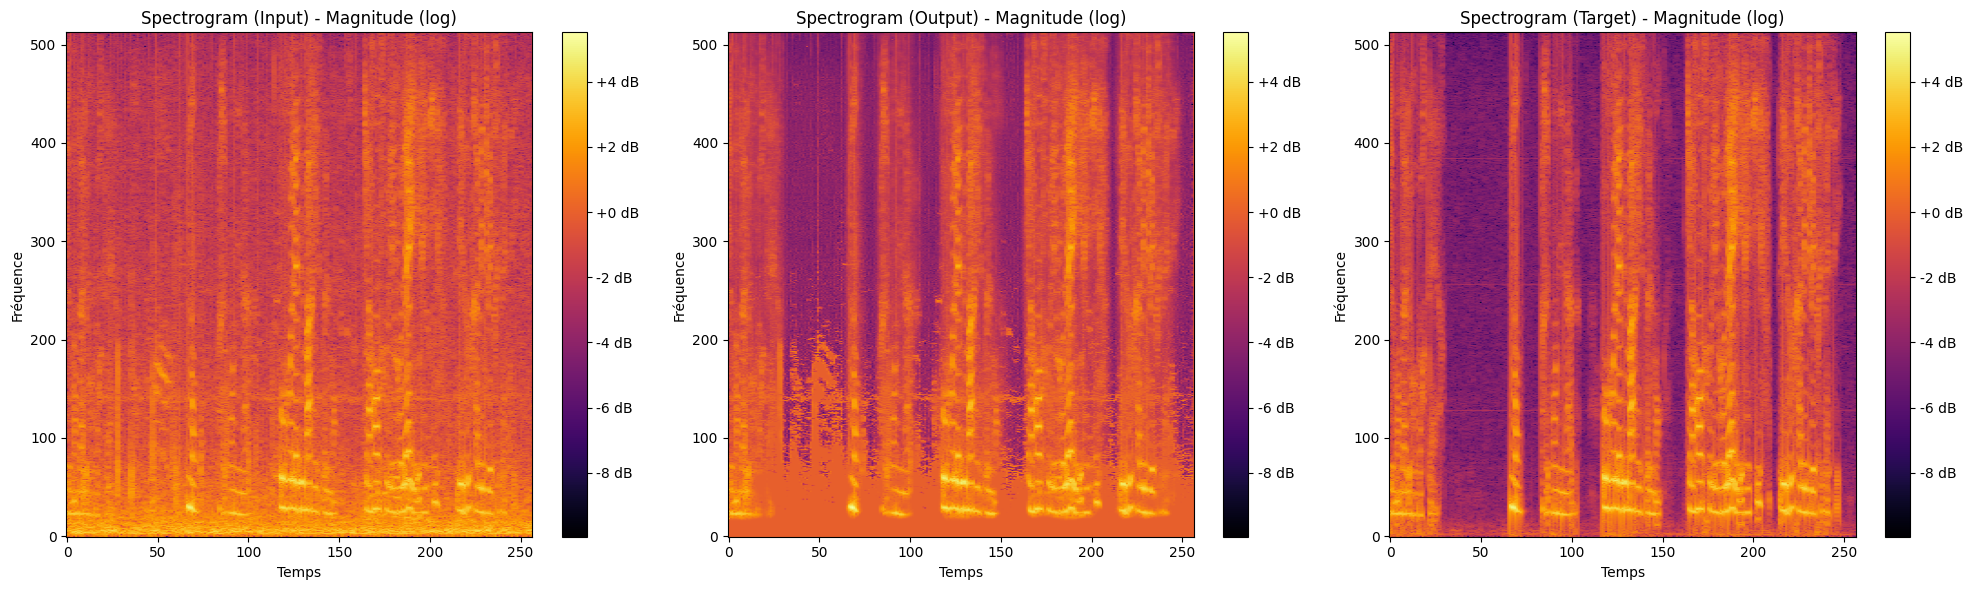

In [50]:
plot_spectrograms(test_x, denoised_output_upsample, test_y)

## **III-2- Évolution de la fonction perte**

## **III-3- Évaluation des performances**

In [51]:
post_name = "20241222_130207"
model_loaded = get_unet(post_name=post_name)

# Uniquement le test 
path_test_x = "data/input/denoising/test"
path_test_y = "data/input/voice_origin/test"
data_loader = DataLoader(path_x=path_test_x, path_y=path_test_y)
harmonized_data = data_loader.get_harmonized_data()

Import summary:
- Data imported successfully!
- Number of noised samples: 608
- Number of original samples: 782
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: False.


In [52]:
### Evaluation process
f_sampling = 8000
list_signals_pred = []

for file_nb in tqdm(range(len(harmonized_data.x))):
    test_x, test_y = harmonized_data.x[file_nb], harmonized_data.y[file_nb]
    spectrogram_noised = Spectrogram(torch.tensor(test_x))
    mask = model_loaded(spectrogram_noised.magnitude[:-1, :-1].float()[None, None, :])
    denoised_output = mask * spectrogram_noised.magnitude[:-1, :-1]
    denoised_output_upsample = upsample_spectrogram(denoised_output)
    denoised_output_upsample_complex = torch.exp(
        denoised_output_upsample + 1j * spectrogram_noised.angle
    )[0, 0]
    denoised_signal = invert_spectrogram(
        denoised_output_upsample_complex,
        n_fft=spectrogram_noised.n_fft,
        hop_length=spectrogram_noised.hop_length,
        win_length=spectrogram_noised.win_length,
        length=spectrogram_noised.signal.shape[0],
    )
    list_signals_pred.append(denoised_signal.detach().numpy())







































































































































































































































































































































































































































































































































































































































100%|██████████| 608/608 [00:39<00:00, 15.48it/s]


In [60]:
MSE, RMSE, SNR, STOI_results, PESQ_results = eval_all_signals(harmonized_data_test.x, harmonized_data_test.y, 8000)
MSE_unet, RMSE_unet, SNR_unet, STOI_results_unet, PESQ_results_unet = eval_all_signals(list_signals_pred, harmonized_data_test.y, 8000)
summary_eval(MSE_unet, RMSE_unet, SNR_unet, STOI_results_unet, PESQ_results_unet)

Metric : mean (std)
___________________
MSE   : 0.0014 (0.0009)
RMSE  : 0.0367 (0.0096)
SNR   : 11.0081 (1.6416)
STOI  : 0.9265 (0.0737)
PESQ  : 2.6744 (0.6221)


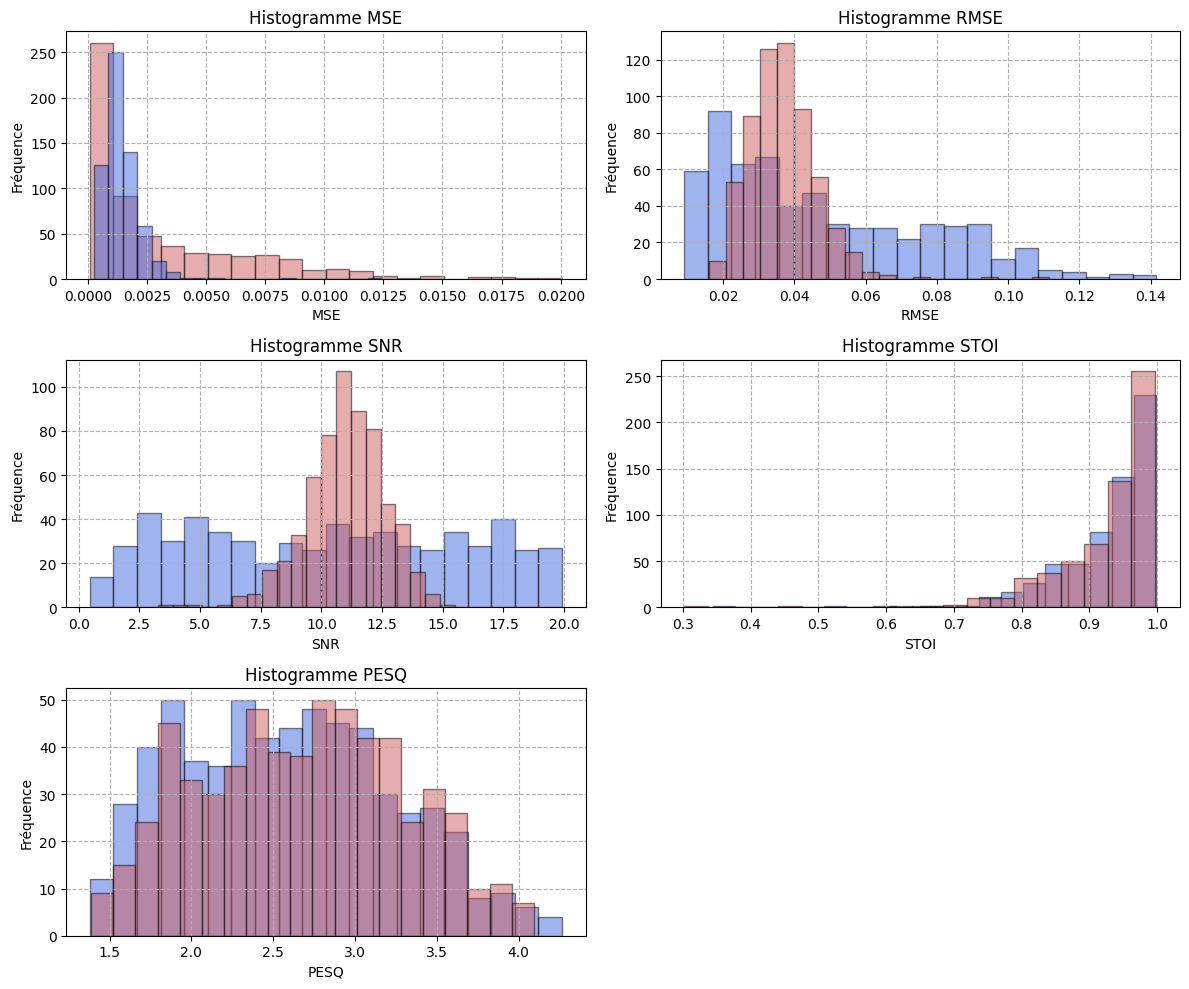

In [61]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10)) 

# Histogramme MSE
axs[0, 0].hist(MSE, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[0, 0].hist(MSE_unet, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[0, 0].grid(linestyle="--")
axs[0, 0].set_title('Histogramme MSE')
axs[0, 0].set_xlabel('MSE')
axs[0, 0].set_ylabel('Fréquence')

# Histogramme RMSE
axs[0, 1].hist(RMSE, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[0, 1].hist(RMSE_unet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[0, 1].grid(linestyle="--")
axs[0, 1].set_title('Histogramme RMSE')
axs[0, 1].set_xlabel('RMSE')
axs[0, 1].set_ylabel('Fréquence')

# Histogramme SNR
axs[1, 0].hist(SNR, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[1, 0].hist(SNR_unet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[1, 0].grid(linestyle="--")
axs[1, 0].set_title('Histogramme SNR')
axs[1, 0].set_xlabel('SNR')
axs[1, 0].set_ylabel('Fréquence')

# Histogramme STOI
axs[1, 1].hist(STOI_results, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[1, 1].hist(STOI_results_unet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[1, 1].grid(linestyle="--")
axs[1, 1].set_title('Histogramme STOI')
axs[1, 1].set_xlabel('STOI')
axs[1, 1].set_ylabel('Fréquence')

# Histogramme PESQ
axs[2, 0].hist(PESQ_results, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[2, 0].hist(PESQ_results_unet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[2, 0].grid(linestyle="--")
axs[2, 0].set_title('Histogramme PESQ')
axs[2, 0].set_xlabel('PESQ')
axs[2, 0].set_ylabel('Fréquence')

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

# **IV- Travail sur la forme d'onde : Wave-U-net**

## **IV-1- Méthodologie Wave-U-Net**
### A remplir 

In [62]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio
import pickle as pkl
from scipy.signal import resample
import torch

In [63]:
from src.model.pipeline_waveunet import PipelineWaveUnet
from src.libs.evaluation import eval_signal
from src.libs.preprocessing import from_numpy_to_torch, from_torch_to_numpy

In [68]:
### CONSTANTS

SAMPLING_FREQUENCY = 8000
ID_EXPERIMENT = 201
pipeline_path = f"output/waveunet_{ID_EXPERIMENT}/training/pipeline.pkl"
train_loss_path = f"output/waveunet_{ID_EXPERIMENT}/training/train_loss.npy"
valid_loss_path = f"output/waveunet_{ID_EXPERIMENT}/training/valid_loss.npy"
array_noised_path = f"output/waveunet_{ID_EXPERIMENT}/testing/array_noised.npy"
array_original_path = f"output/waveunet_{ID_EXPERIMENT}/testing/array_original.npy"
array_denoised_path = f"output/waveunet_{ID_EXPERIMENT}/testing/array_denoised.npy"

In [69]:
### LOAD MODEL AND LOSSES

with open(pipeline_path, "rb") as file:
    pipeline = pkl.load(file)
train_loss = np.load(train_loss_path)
valid_loss = np.load(valid_loss_path)

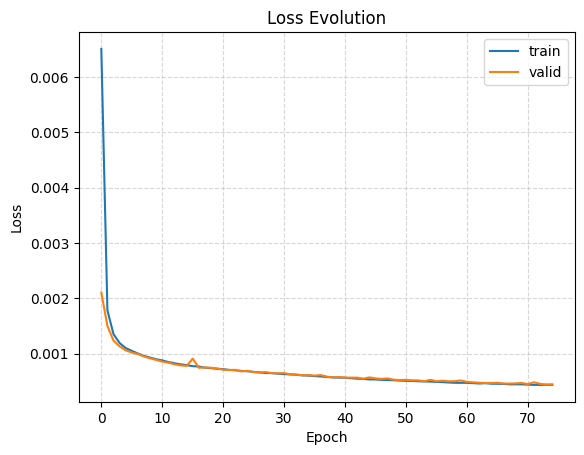

In [70]:
### PLOT LOSS EVOLUTION

plt.plot(train_loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("Loss Evolution")
plt.xlabel("Epoch")
plt.grid(alpha=0.5, linestyle="--")
plt.xticks([i for i in range(train_loss.shape[0]) if i % 10 == 0])
plt.ylabel("Loss")
plt.legend()
plt.show()

In [71]:
### LOAD DATA

array_noised = np.load(array_noised_path)
array_original = np.load(array_original_path)
array_denoised = np.load(array_denoised_path)

KeyboardInterrupt: 

In [ ]:
### CHOOSE A SIGNAL

ID_SIGNAL = 25

noised_signal = array_noised[ID_SIGNAL, :]
original_signal = array_original[ID_SIGNAL, :]
predicted_signal = array_denoised[ID_SIGNAL, :]

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)


noised_resampled = resample_signal(noised_signal, SAMPLING_FREQUENCY, 8000)
original_resampled = resample_signal(original_signal, SAMPLING_FREQUENCY, 8000)
predicted_resampled = resample_signal(predicted_signal, SAMPLING_FREQUENCY, 8000)

print(f"Noised shape : {noised_resampled.shape}")
print(f"Original shape : {original_resampled.shape}")
print(f"Predicted shape : {predicted_resampled.shape}")

## **IV-2- Méthodologie Wave-U-Net**

In [ ]:
# Affichage 
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(noised_resampled, label=f'Signal bruité', color="blue")
plt.title(f'Signal bruité')
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(original_resampled, label=f'Signal propre (référence)', color="green")
plt.title(f'Signal propre (référence)')
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(predicted_resampled, label=f'Signal estimé après filtre de Wiener', color="orange")
plt.title(f'Signal estimé après Wave-U-Net')
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(noised_resampled, label=f'Signal bruité', color="blue", alpha=0.6)
plt.plot(original_resampled, label=f'Signal propre (référence)', color="green", alpha=0.6)
plt.plot(predicted_signal, label=f'Signal estimé après Wave-U-Net', color="orange", alpha=0.6)
plt.title(f'Superposition des trois signaux')
plt.legend(loc="upper right")
plt.grid()

plt.tight_layout()
plt.show()

print("Signal bruité : ")
display(Audio(noised_resampled, rate=f_sampling))

print("Signal débruité : ")
display(Audio(original_resampled.detach().numpy(), rate=f_sampling))

print("Signal target : ")
display(Audio(predicted_resampled, rate=f_sampling))

In [ ]:
MSE_waveunet, RMSE_waveunet, SNR_waveunet, STOI_results_waveunet, PESQ_results_waveunet = eval_all_signals(list_signals_pred, harmonized_data_test.y, 8000)
summary_eval(MSE_waveunet, RMSE_waveunet, SNR_waveunet, STOI_results_waveunet, PESQ_results_waveunet)

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10)) 

# Histogramme MSE
axs[0, 0].hist(MSE, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[0, 0].hist(MSE_waveunet, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[0, 0].grid(linestyle="--")
axs[0, 0].set_title('Histogramme MSE')
axs[0, 0].set_xlabel('MSE')
axs[0, 0].set_ylabel('Fréquence')

# Histogramme RMSE
axs[0, 1].hist(RMSE, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[0, 1].hist(RMSE_waveunet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[0, 1].grid(linestyle="--")
axs[0, 1].set_title('Histogramme RMSE')
axs[0, 1].set_xlabel('RMSE')
axs[0, 1].set_ylabel('Fréquence')

# Histogramme SNR
axs[1, 0].hist(SNR, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[1, 0].hist(SNR_waveunet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[1, 0].grid(linestyle="--")
axs[1, 0].set_title('Histogramme SNR')
axs[1, 0].set_xlabel('SNR')
axs[1, 0].set_ylabel('Fréquence')

# Histogramme STOI
axs[1, 1].hist(STOI_results, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[1, 1].hist(STOI_results_waveunet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[1, 1].grid(linestyle="--")
axs[1, 1].set_title('Histogramme STOI')
axs[1, 1].set_xlabel('STOI')
axs[1, 1].set_ylabel('Fréquence')

# Histogramme PESQ
axs[2, 0].hist(PESQ_results, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[2, 0].hist(PESQ_results_waveunet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[2, 0].grid(linestyle="--")
axs[2, 0].set_title('Histogramme PESQ')
axs[2, 0].set_xlabel('PESQ')
axs[2, 0].set_ylabel('Fréquence')

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

# **V - Conclusion**

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10)) 

# Histogramme MSE
axs[0, 0].hist(MSE, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[0, 0].hist(MSE_wiener, bins=20, edgecolor='black', alpha=0.5, color="golden", label="Wiener")
axs[0, 0].hist(MSE_unet, bins=20, edgecolor='black', alpha=0.5, color="golden", label="Unet")
axs[0, 0].hist(MSE_waveunet, bins=20, edgecolor='black', alpha=0.5, color="royalblue", label="WaveUnet")
axs[0, 0].grid(linestyle="--")
axs[0, 0].set_title('Histogramme MSE')
axs[0, 0].set_xlabel('MSE')
axs[0, 0].set_ylabel('Fréquence')

# Histogramme RMSE
axs[0, 1].hist(RMSE, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[0, 1].hist(RMSE_unet, bins=20, edgecolor='black', alpha=0.5, color="golden")
axs[0, 1].hist(RMSE_waveunet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[0, 1].grid(linestyle="--")
axs[0, 1].set_title('Histogramme RMSE')
axs[0, 1].set_xlabel('RMSE')
axs[0, 1].set_ylabel('Fréquence')

# Histogramme SNR
axs[1, 0].hist(SNR, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[1, 0].hist(SNR_waveunet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[1, 0].grid(linestyle="--")
axs[1, 0].set_title('Histogramme SNR')
axs[1, 0].set_xlabel('SNR')
axs[1, 0].set_ylabel('Fréquence')

# Histogramme STOI
axs[1, 1].hist(STOI_results, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[1, 1].hist(STOI_results_waveunet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[1, 1].grid(linestyle="--")
axs[1, 1].set_title('Histogramme STOI')
axs[1, 1].set_xlabel('STOI')
axs[1, 1].set_ylabel('Fréquence')

# Histogramme PESQ
axs[2, 0].hist(PESQ_results, bins=20, edgecolor='black', alpha=0.5, color="royalblue")
axs[2, 0].hist(PESQ_results_waveunet, bins=20, edgecolor='black', alpha=0.5, color="indianred")
axs[2, 0].grid(linestyle="--")
axs[2, 0].set_title('Histogramme PESQ')
axs[2, 0].set_xlabel('PESQ')
axs[2, 0].set_ylabel('Fréquence')

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()